In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm


sys.path.append(os.path.abspath(os.path.join('..')))

from models.KMeans import KMeans
from models.GMM import GMM
from models.DBSCAN import DBSCAN
from models.PCA import PCA
from models.VAE import VAE
from models.utils import normalize, kmeans_elbow_analysis, plot_kmeans_clusters, gmm_log_likelihood_curve, plot_gmm_clusters, grid_search_dbscan, plot_dbscan_clusters, plot_reconstructions_vae, plot_reconstructions_pca, get_one_index_per_digit

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [56]:
data = pd.read_csv("../data/clustering.csv").values[:, 1:]
data_std, mean, std = normalize(data)

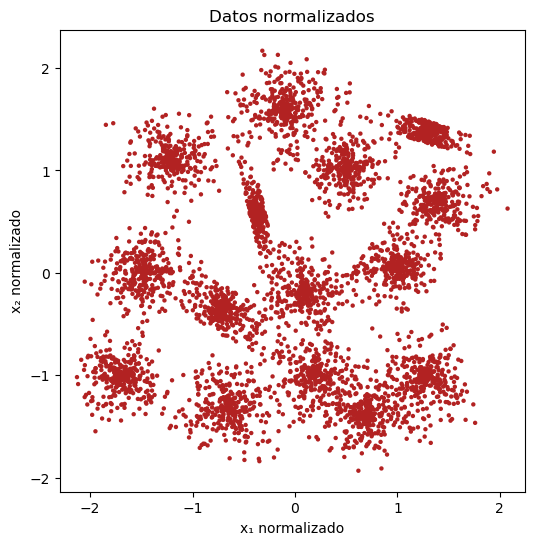

In [57]:
plt.figure(figsize=(6, 6))
plt.scatter(data_std[:, 0], data_std[:, 1], s=10, color="firebrick", edgecolor="none")
plt.xlabel("x₁ normalizado")
plt.ylabel("x₂ normalizado")
plt.title("Datos normalizados")
plt.axis("equal")
plt.show()

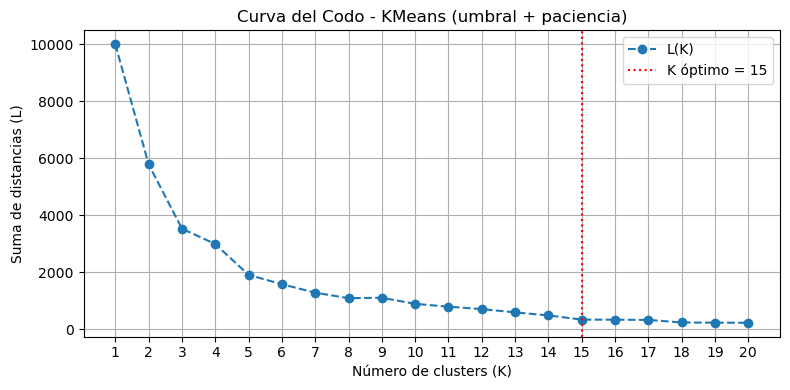

In [ ]:
k_opt_KMeans = kmeans_elbow_analysis(data_std, K_range=range(1, 21), random_state=RANDOM_SEED, improvement_threshold=0.03, patience=3)

In [59]:
kmeans = KMeans(n_clusters=k_opt_KMeans, random_state=RANDOM_SEED)
kmeans.fit(data_std)

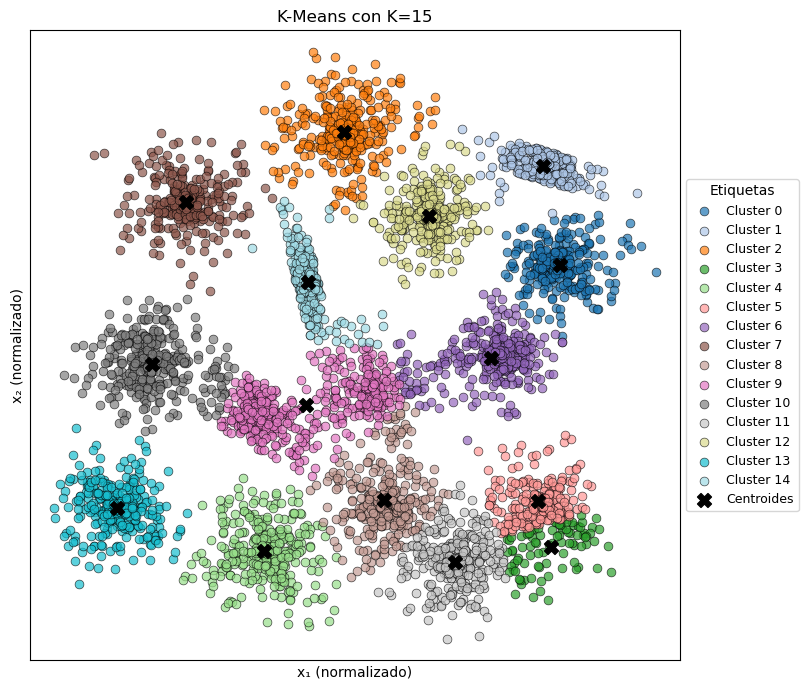

In [60]:
plot_kmeans_clusters(data_std, kmeans.labels_, kmeans.centroids, title=f"K-Means con K={k_opt_KMeans}")

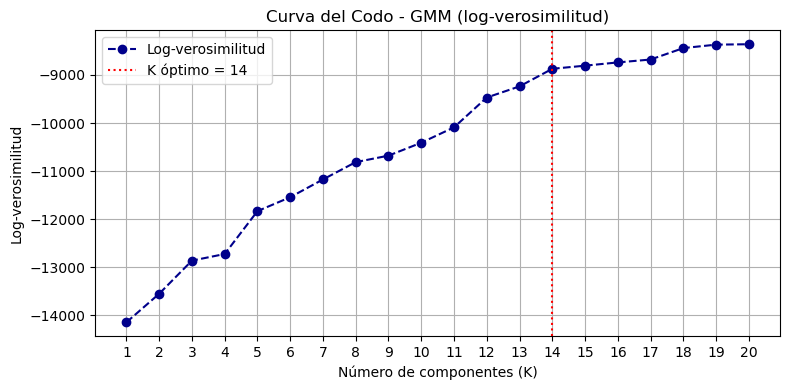

In [73]:
K_range = range(1, 21)
k_opt_GMM = gmm_log_likelihood_curve(data_std, K_range, random_state=RANDOM_SEED, improvement_threshold=0.03, patience=3)

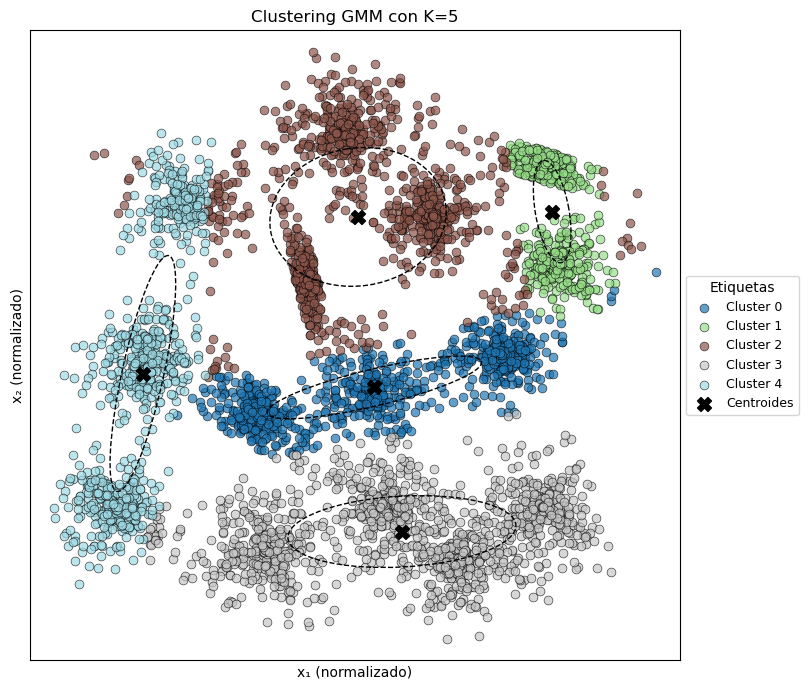

In [62]:
kmeans_for_gmm = KMeans(n_clusters=k_opt_GMM, random_state=RANDOM_SEED)
kmeans_for_gmm.fit(data_std)

gmm = GMM(n_components=k_opt_GMM, random_state=RANDOM_SEED, means_init=kmeans_for_gmm.centroids)
gmm.fit(data_std)
labels = gmm.predict(data_std)

plot_gmm_clusters(data_std, labels, gmm.means_, gmm.covariances_, title=f"Clustering GMM con K={k_opt_GMM}")


Grid DBSCAN: 100%|██████████| 24/24 [00:05<00:00,  4.25it/s]


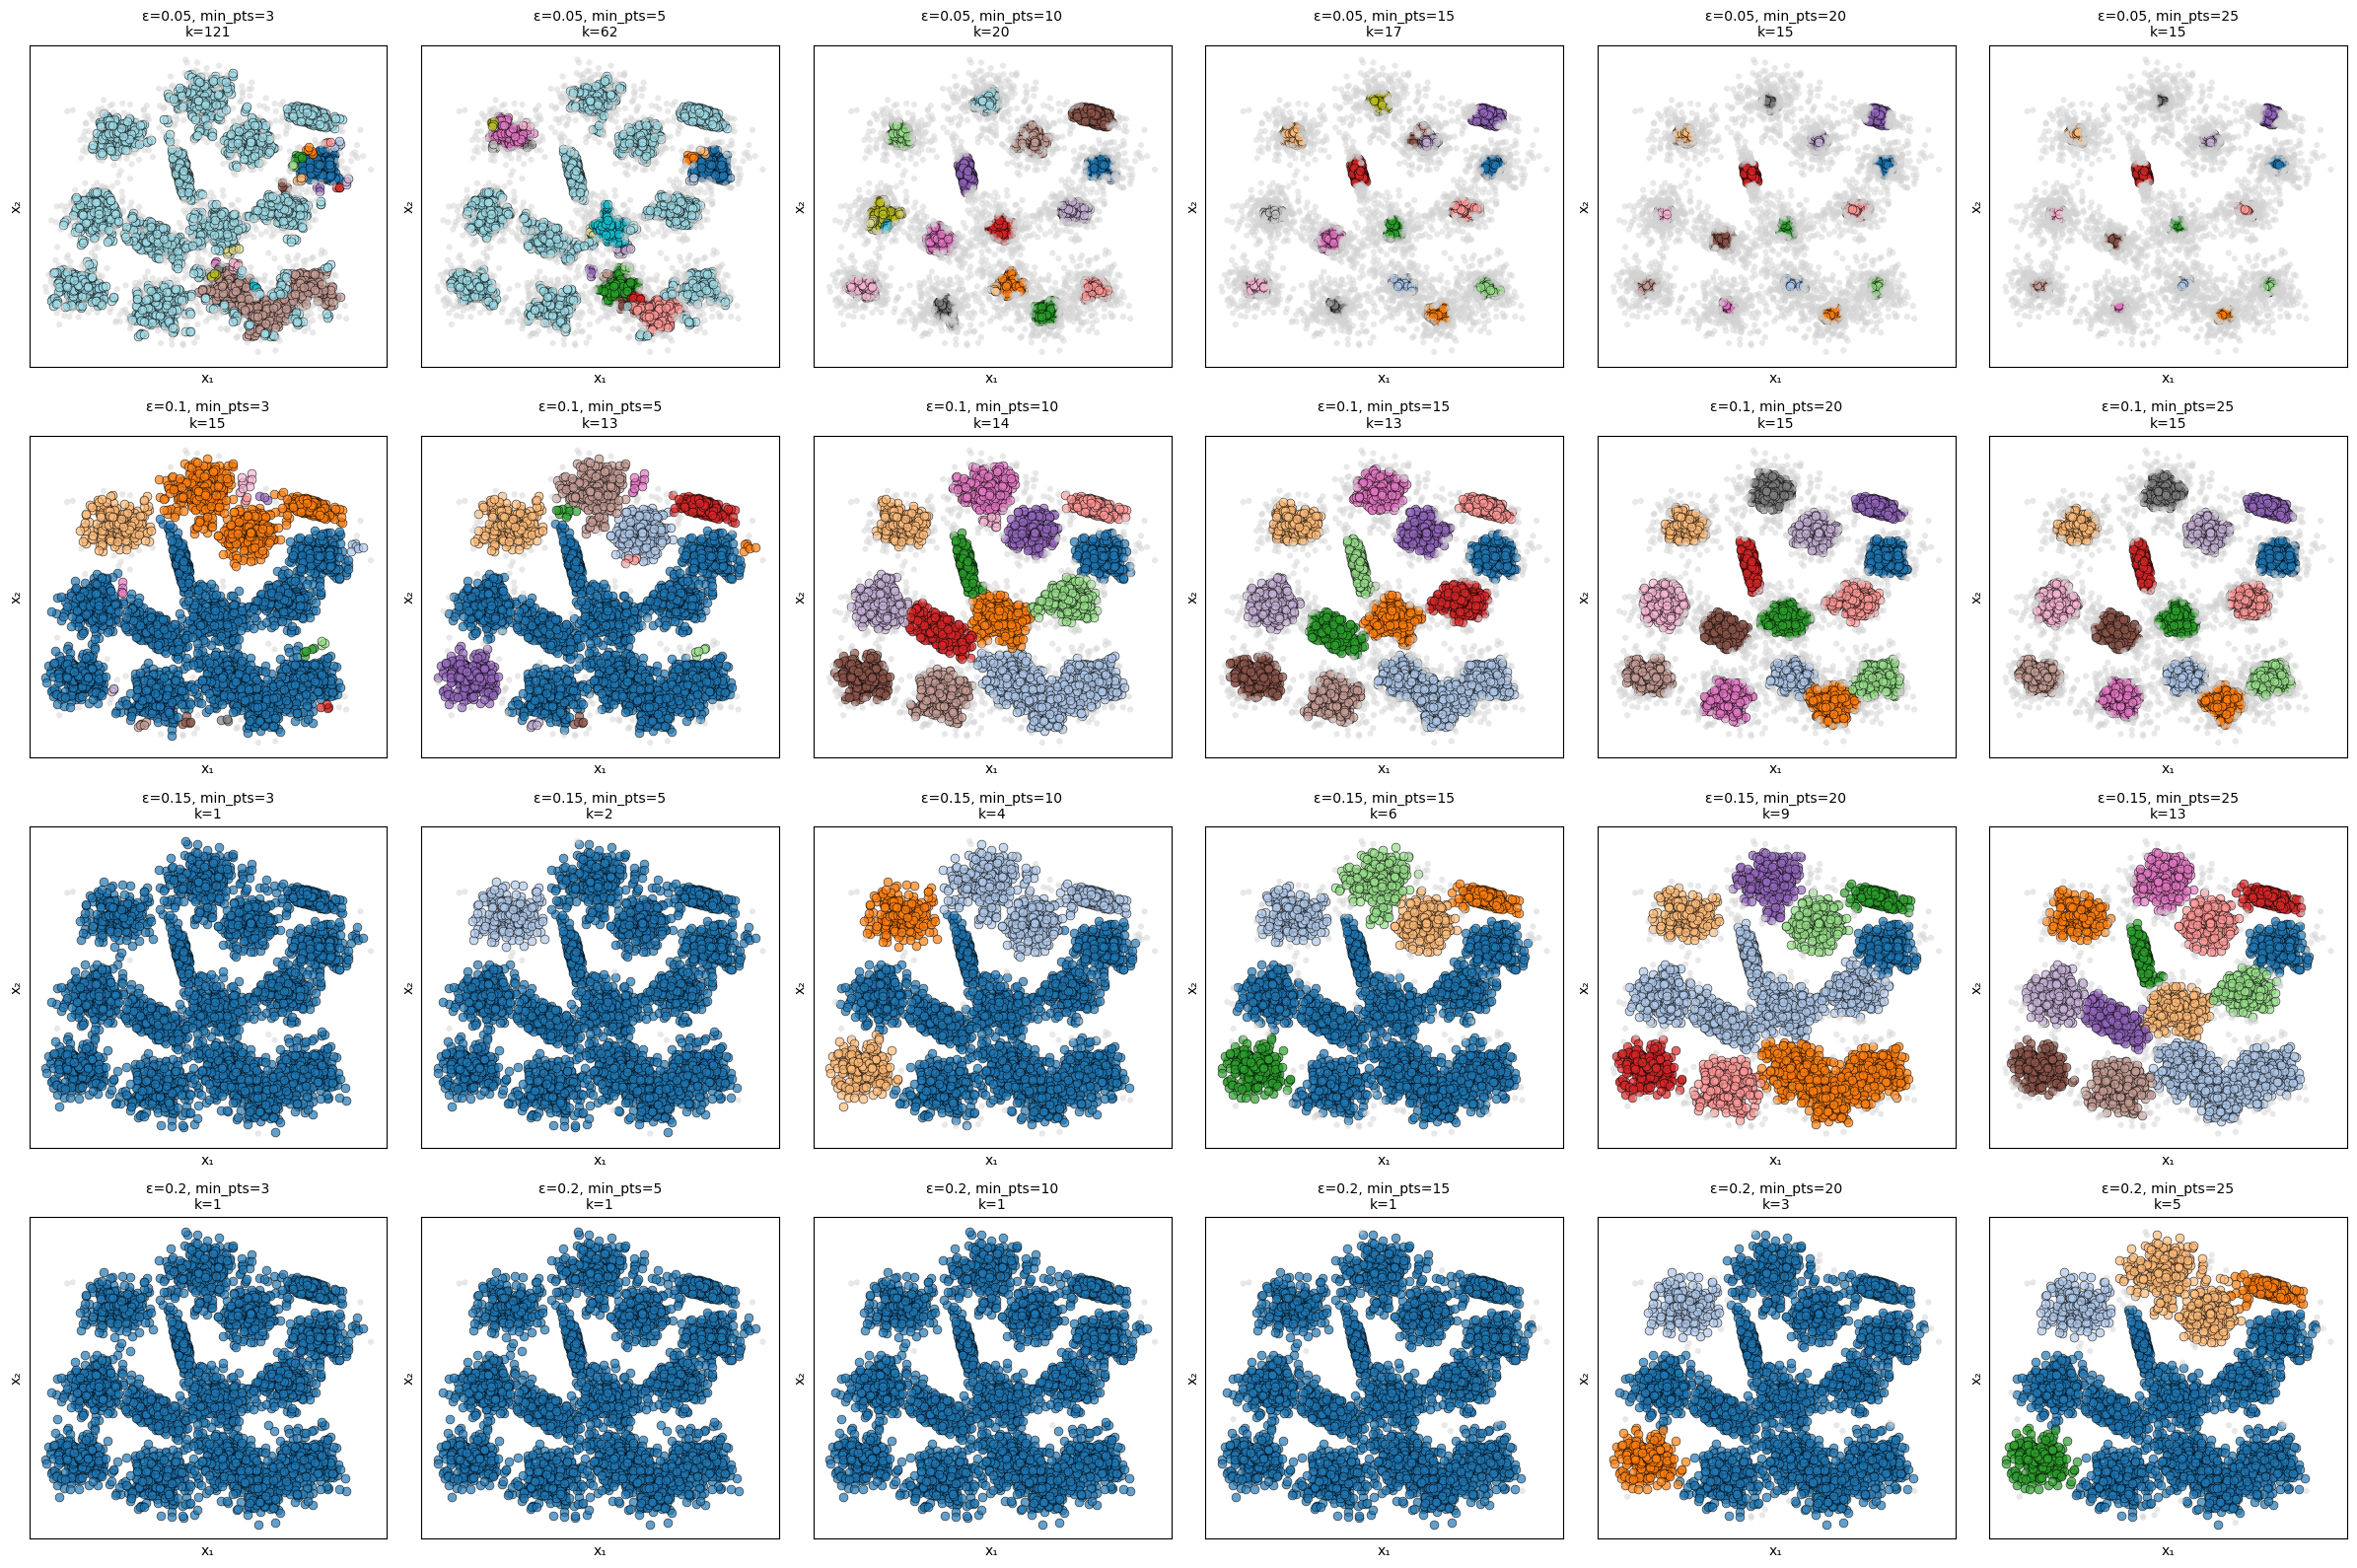

In [63]:
# Definimos valores a probar
eps_list = [0.05, 0.1, 0.15, 0.2]
min_samples_list = [3, 5, 10, 15, 20, 25]

# Ejecutamos el grid search y graficamos resultados
results = grid_search_dbscan(data_std, eps_list, min_samples_list)

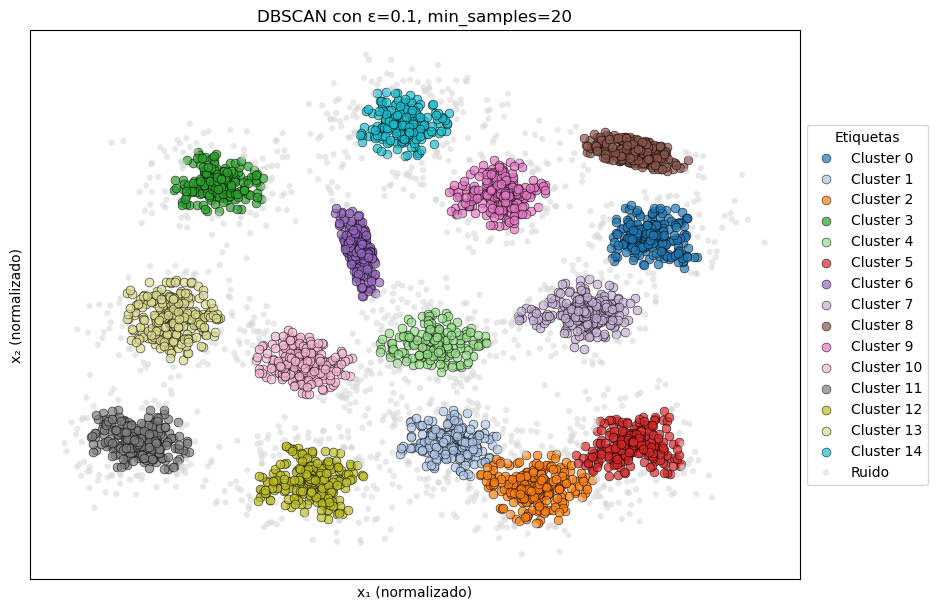

In [64]:
# Ejecutar DBSCAN con valores elegidos
min_samples = 20
eps = 0.1

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(data_std)

# Graficar resultado
plot_dbscan_clusters(data_std, dbscan.labels_, title=f"DBSCAN con ε={eps}, min_samples={min_samples}")


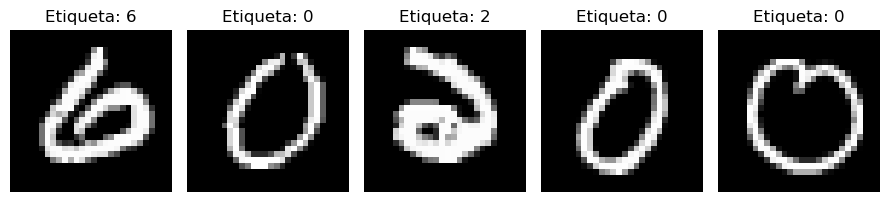

In [65]:
df = pd.read_csv("../data/MNIST_dataset.csv")
X = df.iloc[:, 1:].values.reshape(-1, 28, 28)  # imágenes (70000, 28, 28)
y = df['label'].values  # etiquetas (70000,)

indices = np.random.choice(len(X), 5, replace=False)

# Mostrar imágenes
fig, axes = plt.subplots(1, 5, figsize=(9, 3))
for ax, idx in zip(axes, indices):
    ax.imshow(X[idx], cmap='gray')
    ax.set_title(f"Etiqueta: {y[idx]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

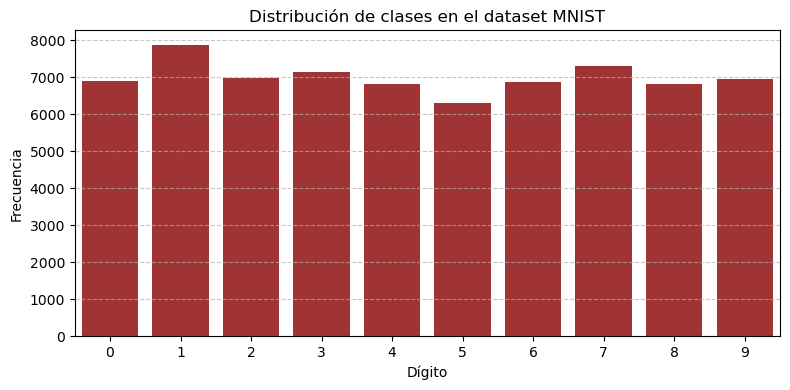

In [66]:
plt.figure(figsize=(8, 4))
sns.countplot(x=y, color='firebrick')
plt.title("Distribución de clases en el dataset MNIST")
plt.xlabel("Dígito")
plt.ylabel("Frecuencia")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [67]:
X_flat = df.iloc[:, 1:].values.astype(np.float32) / 255.0  # Normalizar a [0, 1]
y = df.iloc[:, 0].values.astype(int)

In [68]:
X_tensor = torch.tensor(X_flat)
y_tensor = torch.tensor(y)

dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

In [71]:
max_components = 400  # cantidad máxima de componentes a probar
errors = []

for k in tqdm(range(1, max_components + 1), desc="PCA components"):
    pca = PCA(n_components=k)
    pca.fit(X_flat)
    err = pca.reconstruction_error(X_flat)
    errors.append(err)

# Graficar
plt.figure(figsize=(8, 4))
plt.plot(range(1, max_components + 1), errors, color='orange')
plt.xlabel("Número de Componentes Principales (k)")
plt.ylabel("Error Cuadrático Medio de Reconstrucción")
plt.title("Error de reconstrucción vs número de componentes principales")
plt.grid(True)
plt.tight_layout()
plt.show()

PCA components:   8%|▊         | 33/400 [00:49<09:13,  1.51s/it]


KeyboardInterrupt: 

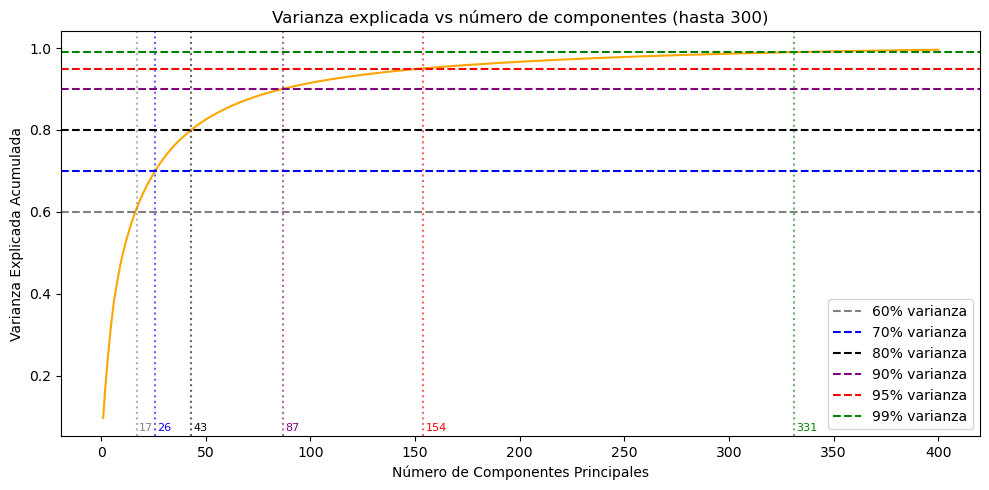

In [ ]:
# Ajustar PCA
pca = PCA(n_components=None)
pca.fit(X_flat)
explained_ratio = pca.explained_variance_ratio()
cumulative_variance = np.cumsum(explained_ratio)

# Filtrar hasta 300 componentes máximo
max_components = 400
cumulative_variance = cumulative_variance[:max_components]

thresholds = [0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
threshold_indices = [np.argmax(cumulative_variance >= t) + 1 for t in thresholds]  # +1 para contar desde 1

# Colores asociados a cada umbral
colors = ['gray', 'blue', 'black', 'purple', 'red', 'green']

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, color='orange')

for t, idx, color in zip(thresholds, threshold_indices, colors):
    plt.axhline(y=t, color=color, linestyle='--', label=f"{int(t*100)}% varianza")
    plt.axvline(x=idx, color=color, linestyle=':', alpha=0.6)
    plt.text(idx + 1, 0.06, str(idx), color=color, ha='left', va='bottom', fontsize=8)

plt.xlabel("Número de Componentes Principales")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Varianza explicada vs número de componentes (hasta 300)")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
pca = PCA(n_components=100)
pca.fit(X_flat)

In [ ]:
indices = get_one_index_per_digit(y)

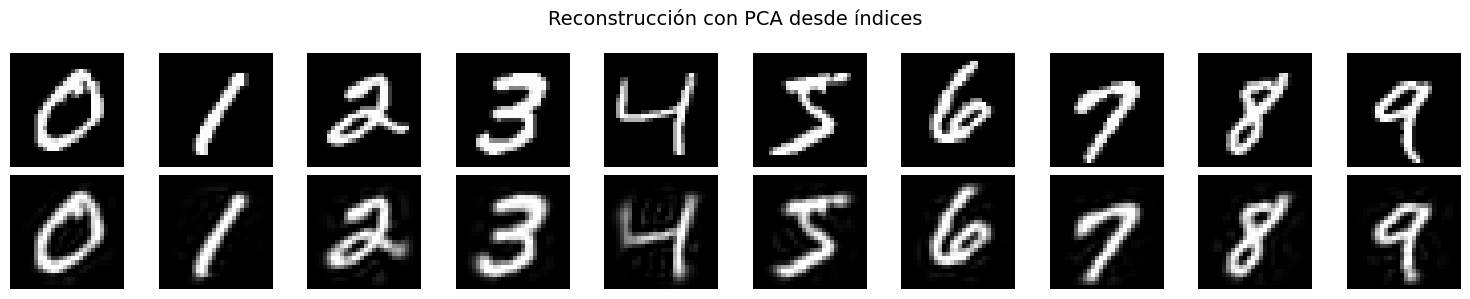

In [ ]:
plot_reconstructions_pca(pca, X_flat, indices)

In [ ]:
vae = VAE()
history = vae.fit(train_loader, val_loader, epochs=50)

Entrenando VAE: 100%|█████████████████| 50/50 [01:58<00:00,  2.37s/it, epoch=50, train_loss=101.6157, val_loss=102.9594]


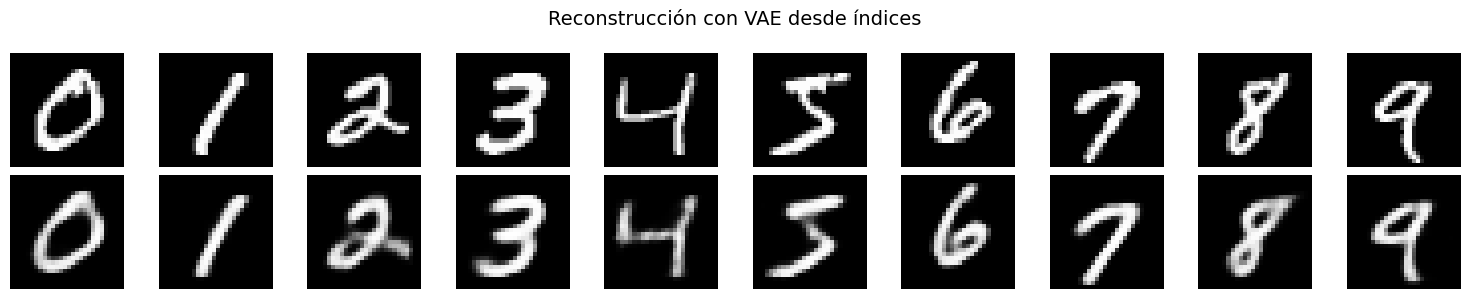

In [ ]:
plot_reconstructions_vae(vae, X_tensor=X_tensor, indices=indices)